In [78]:
from typing import TypeVar, Generic, List, Final
import numpy as np
import math

T = TypeVar('T')


class WeightedEntry(Generic[T]):

    def __init__(self, weight: float, index:int, data: T):
        self.weight: Final = weight
        self.index: Final = index
        self.data: Final = data


class RandomList(Generic[T]):

    def __init__(self):
        self.list: List[WeightedEntry[T]] = []
        self.sum_weight = 0

    def add_entry(self, weight: float, obj: T):
        if weight <= 0:
            raise AssertionError("invalid weight: " + str(weight))
        self.list.append(WeightedEntry(weight, len(self.list), obj))
        self.sum_weight += weight

    def get_random_entry(self, rand_number: float):
        if rand_number < 0 or rand_number > 1 or len(self.list) == 0 or self.sum_weight <= 0:
            raise AssertionError("invalid list")
        rand_number *= self.sum_weight
        for entry in self.list:
            rand_number -= entry.weight
            if rand_number < 0:
                return entry
        raise AssertionError("failed to find entry")


class GaussianVariable(object):

    def __init__(self, n: int, mean: np.ndarray, a: np.ndarray):
        self.n = n
        self.mean = mean
        self.a = a
        if mean.shape != (n,):
            raise AssertionError("mean dimension mismatch")
        if a.shape != (n, n):
            raise AssertionError("cov dimension mismatch")

    def sample_data(self):
        iid = np.random.standard_normal((self.n,))
        return self.mean + np.matmul(self.a, iid)

    def get_density(self, data: np.ndarray):
        c = np.matmul(self.a, np.transpose(self.a))
        x = data - self.mean
        coef = math.pow(2 * math.pi * np.linalg.det(c), -1 / 2)
        expm = -np.matmul(np.matmul(x, np.linalg.inv(c)), np.transpose(x)) / 2
        return coef * math.exp(expm)


class GaussianMixture(RandomList[GaussianVariable]):

    def __init__(self, n: int):
        super().__init__()
        self.n = n

    def add_gaussian(self, weight: float, mean: np.ndarray, a: np.ndarray):
        self.add_entry(weight, GaussianVariable(self.n, mean, a))

    def get_random_data(self, size: int, seed: int = 0):
        np.random.seed(seed)
        choice = np.random.random((size,))

        def parse(entry: WeightedEntry[GaussianVariable]):
            vec = entry.data.sample_data()
            return [vec[0], vec[1], entry.index]

        return np.asarray([parse(self.get_random_entry(val)) for val in choice], np.float32)

    def get_density(self, data: np.ndarray):
        chance = 0
        for entry in self.list:
            chance += entry.weight * entry.data.get_density(data)
        return chance


class DataFrame(object):

    def __init__(self, train, test, n_train, n_test, d:int = 2):
        self.train = train
        self.test = test
        self.n_train = n_train
        self.n_test = n_test
        self.d = d

class DataSection(object):

    def __init__(self, data: DataFrame, train: bool, n:int):
        self.n = n
        chosen = data.train if train else data.test
        self.data = chosen[0:n,0:data.d]
        self.label = np.array(chosen[0:n,data.d], dtype=np.int32)


class KMean(DataSection):

    def __init__(self, data: DataFrame, train: bool, n:int, k:int, large = 1e6):
        super().__init__(data, train, n)
        self.k = k
        self.d = data.d
        self.large = large
        self.m = np.zeros((k,self.d), np.float32)
        self.assign = np.zeros((self.n), np.int32)
    
    def init_kpp(self, seed):
        np.random.seed(seed)
        choices = np.random.random((self.k,))
        prob = np.ones((self.n), np.float32)
        for i in range(self.k):
            choice = choices[i] * sum(prob)
            for j in range(self.n):
                choice -= prob[j]
                if choice <= 0:
                    self.m[i] = self.data[j]
                    break
            for j in range(self.n):
                min_dist = self.large
                for k in range(i+1):
                    diff = self.data[j] - self.m[k]
                    dist = np.dot(diff, diff)
                    min_dist = min(min_dist, dist)
                prob[j] = min_dist

    def init_random(self, seed):
        np.random.seed(seed)
        for i in range(self.k):
            self.m[i] = self.data[np.random.randint(self.n)]
                    
    def optimize_assign(self):
        sd = np.full((self.k, self.n, self.d), self.data)
        sm = np.full((self.n, self.k, self.d), self.m)
        sdf = sd - sm.swapaxes(0, 1)
        self.assign = np.argmin(np.linalg.norm(sdf, axis=2), 0)

    def test(self):
        diff = self.data - self.m[self.assign]
        return np.sum(np.square(diff)) / self.n

    def optimize_m(self):
        for i in range(self.k):
            self.m[i] = np.mean(self.data[self.assign == i],0)



In [19]:
import math
import numpy as np
import matplotlib.pyplot as plt

def a_from_eigen_angle(eig_1, eig_2, theta):
    eig_vector = np.transpose(np.array([[math.cos(theta), math.sin(theta)], 
            [-math.sin(theta), math.cos(theta)]]))
    eig_value = np.diag([math.sqrt(eig_1), math.sqrt(eig_2)])
    return np.matmul(eig_vector, eig_value)

mixture = GaussianMixture(2)
mixture.add_gaussian(1 / 3, np.array([4, 0]), 
        a_from_eigen_angle(1, 4, 0))
mixture.add_gaussian(1 / 6, np.array([-3, 3]), 
        a_from_eigen_angle(1, 4, math.pi / 4))
mixture.add_gaussian(3 / 8, np.array([0, 0]), 
        a_from_eigen_angle(1, 2, math.pi / 3))
mixture.add_gaussian(1 / 8, np.array([-6, -4]), 
        a_from_eigen_angle(2, 1, math.pi / 4))

In [20]:

n = 100000
sample_train = mixture.get_random_data(n, 0)
sample_test = mixture.get_random_data(n, 12345)
data = DataFrame(sample_train, sample_test, n, n)

In [21]:
def random_init(model: KMean, initializer, salt: int, n:int):
    best_init = 0
    best_loss = 1e6
    for i in range(n):
        initializer(model, salt + i)
        model.optimize_assign()
        loss = model.test()
        if loss < best_loss:
            best_loss = loss
            best_init = i
    initializer(model, salt + best_init)
    model.optimize_assign()

def train(model: KMean, eps: float):
    prev = 1e6
    loss_list = []
    loss = model.test()
    loss_list.append(loss)
    while prev-loss > eps:
        model.optimize_m()
        model.optimize_assign()
        prev = loss
        loss = model.test()
        loss_list.append(loss)
    return {"m":model.m, "loss":loss_list}

def plot_scatter(axs: plt.Axes, model: KMean, s=5):
    for i in range(model.k):
        data = model.data[model.assign==i]
        axs.scatter(data[:,0], data[:,1], s=s)
        axs.set_aspect('equal', 'box')

def train_and_plot(axs: plt.Axes, n, k, func = KMean.init_random, n_init = 10, salt = 45242, eps = 1e-4, s=5):
    model = KMean(data, True, n, k)
    random_init(model, func, salt + n + k, n_init)
    result = train(model, eps)
    axs.set_title(f'K = {k}')
    plot_scatter(axs, model, s)
    return result

        

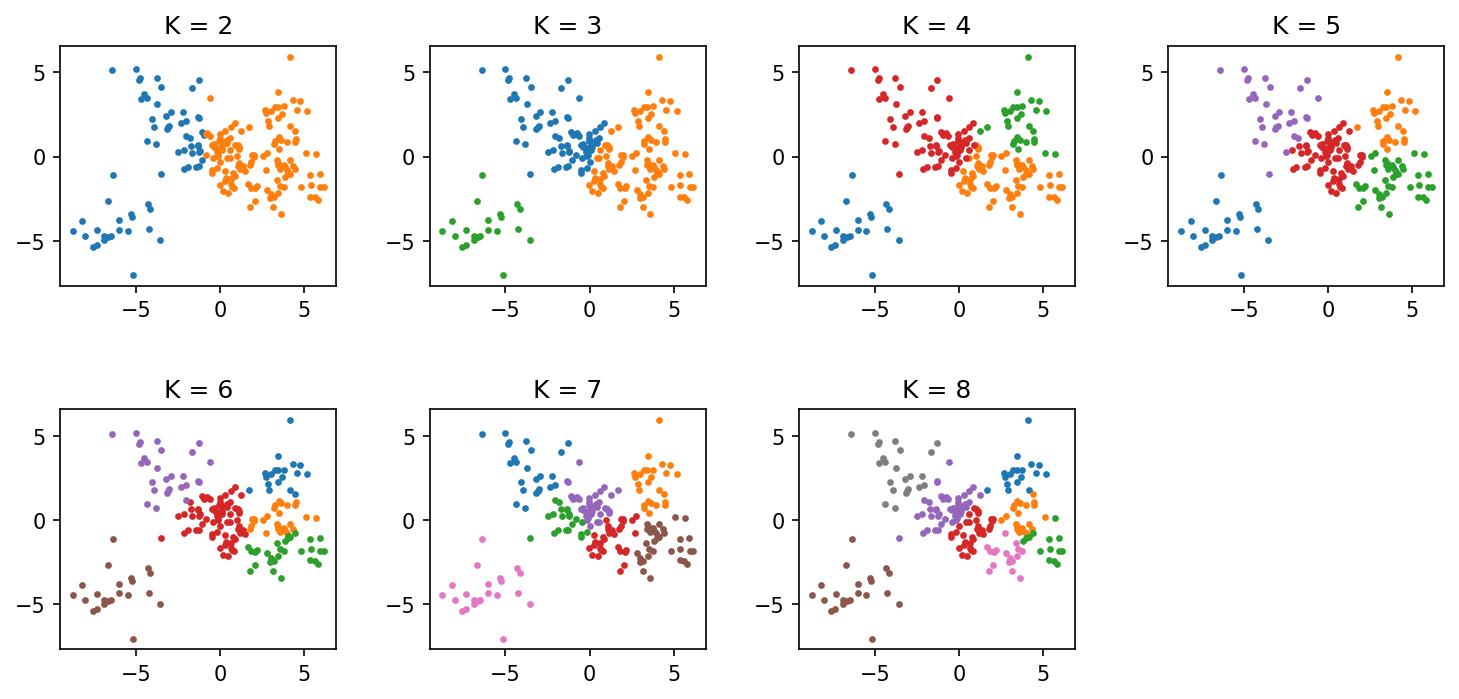

In [25]:
fig, axs = plt.subplots(2, 4, dpi = 150, figsize = (10,5))
fig.tight_layout()
results_rand = [
train_and_plot(axs[0,0], 200, 2),
train_and_plot(axs[0,1], 200, 3),
train_and_plot(axs[0,2], 200, 4),
train_and_plot(axs[0,3], 200, 5),
train_and_plot(axs[1,0], 200, 6),
train_and_plot(axs[1,1], 200, 7),
train_and_plot(axs[1,2], 200, 8)]
fig.delaxes(axs[1,3])

In [122]:
def test_and_list(m, n, k):
    model = KMean(data, False, n, k)
    model.m = m
    model.optimize_assign()
    table = np.zeros((4,k))
    tot = 0
    for i in range(4):
        for j in range(k):
            table[i,j] = np.mean(model.assign[model.label == i] == j)*100
            if table[i,j]>50:
                tot += np.sum(model.assign[model.label == i] != j)
    return {"table":table,"total":tot}

In [123]:
for i in range(7):
    print(np.round(test_and_list(results_rand[i]["m"], 100000, i+2)["table"], decimals=1))

[[  0.  100. ]
 [ 91.1   8.9]
 [ 25.5  74.5]
 [100.    0. ]]
[[ 0.2 99.8  0. ]
 [98.8  1.2  0. ]
 [60.2 39.8  0. ]
 [ 1.   0.  99. ]]
[[ 0.  53.  46.9  0.1]
 [ 0.   1.   0.2 98.8]
 [ 0.  37.4  2.3 60.2]
 [99.   0.   0.   1. ]]
[[ 0.  41.  57.4  1.6  0. ]
 [ 0.   0.1  0.1 13.9 85.9]
 [ 0.   1.5  6.8 84.9  6.8]
 [99.1  0.   0.   0.6  0.4]]
[[24.5 41.5 33.4  0.7  0.   0. ]
 [ 0.1  0.1  0.  16.1 83.6  0. ]
 [ 0.6  7.7  3.8 83.1  4.9  0. ]
 [ 0.   0.   0.   0.8  0.2 99. ]]
[[ 0.  40.1  0.   6.6  0.7 52.6  0. ]
 [75.6  0.  12.6  0.8 10.9  0.   0. ]
 [ 1.9  0.9 30.  32.2 33.4  1.4  0. ]
 [ 0.   0.   2.2  0.   0.   0.  97.8]]
[[22.2 39.6 20.1  1.8  0.1  0.  16.2  0. ]
 [ 0.1  0.   0.   1.5 23.   0.   0.  75.3]
 [ 0.7  2.6  0.1 43.3 46.9  0.   4.4  2. ]
 [ 0.   0.   0.   0.   0.8 99.   0.   0.1]]


Text(0.5, 1.0, '∆^-2(K)-∆^-2(K-1)')

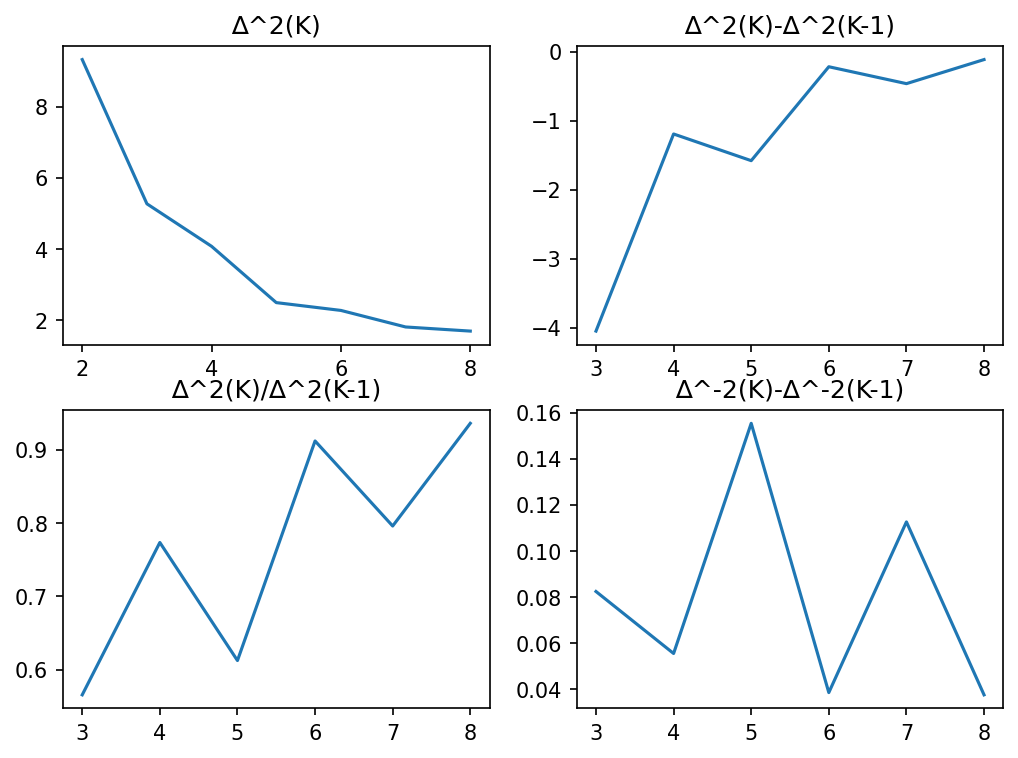

In [45]:
rate = np.array([r["loss"][-1] for r in results_rand])
fig, axs = plt.subplots(2,2,dpi=150, figsize=(7,5))
fig.tight_layout()
axs[0][0].plot([i+2 for i in range(7)],rate)
axs[0][0].set_title('∆^2(K)')
axs[0][1].plot([i+3 for i in range(6)],rate[1:7]-rate[0:6])
axs[0][1].set_title('∆^2(K)-∆^2(K-1)')
axs[1][0].plot([i+3 for i in range(6)],rate[1:7]/rate[0:6])
axs[1][0].set_title('∆^2(K)/∆^2(K-1)')
axs[1][1].plot([i+3 for i in range(6)],1/rate[1:7]-1/rate[0:6])
axs[1][1].set_title('∆^-2(K)-∆^-2(K-1)')

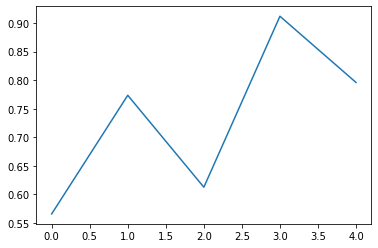

In [46]:

plt.plot([rate[i+1]/rate[i] for i in range(5)])

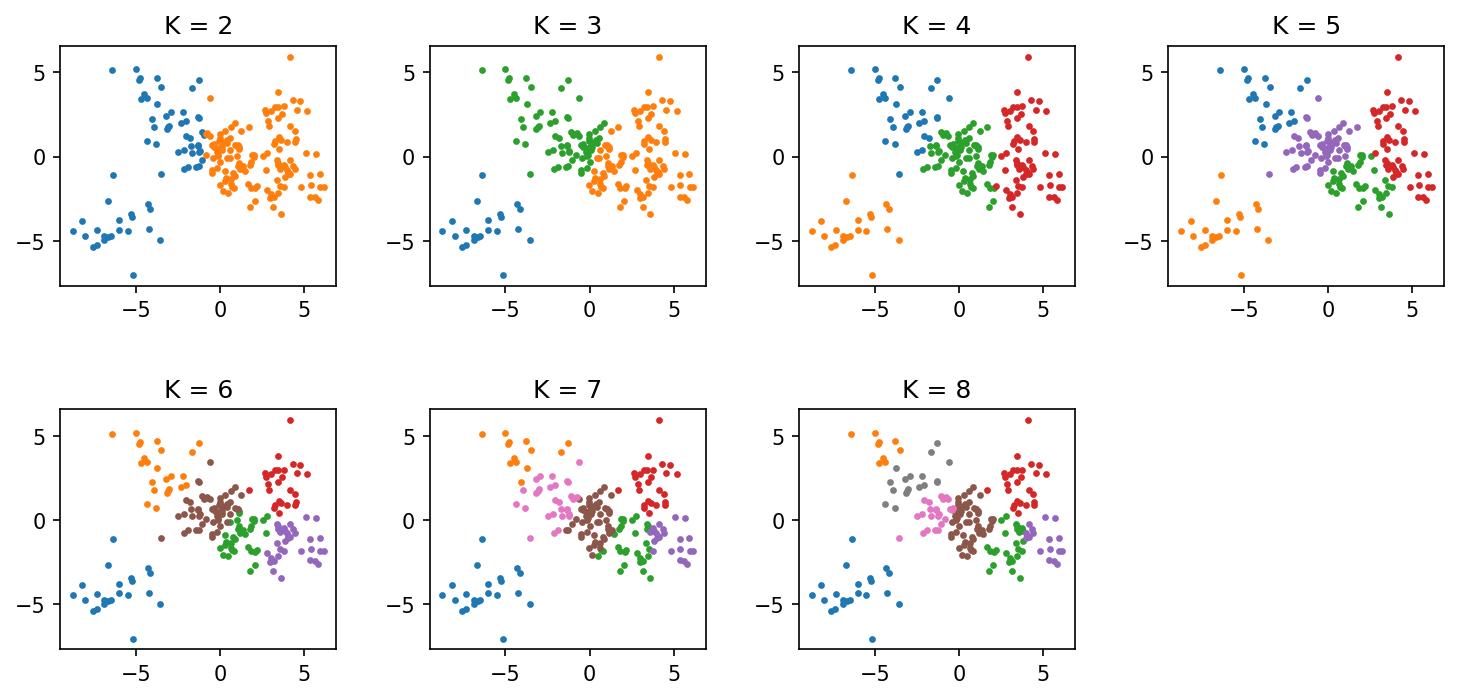

In [47]:
fig, axs = plt.subplots(2, 4, dpi = 150, figsize = (10,5))
fig.tight_layout()
results_kpp = [
train_and_plot(axs[0,0], 200, 2, func = KMean.init_kpp),
train_and_plot(axs[0,1], 200, 3, func = KMean.init_kpp),
train_and_plot(axs[0,2], 200, 4, func = KMean.init_kpp),
train_and_plot(axs[0,3], 200, 5, func = KMean.init_kpp),
train_and_plot(axs[1,0], 200, 6, func = KMean.init_kpp),
train_and_plot(axs[1,1], 200, 7, func = KMean.init_kpp),
train_and_plot(axs[1,2], 200, 8, func = KMean.init_kpp)]
fig.delaxes(axs[1,3])

In [125]:
for i in range(7):
    print(np.round(test_and_list(results_kpp[i]["m"], 100000, i+2)["table"], decimals=1))

[[  0.  100. ]
 [ 91.1   8.9]
 [ 25.5  74.5]
 [100.    0. ]]
[[ 0.  99.8  0.2]
 [ 0.   1.2 98.8]
 [ 0.  39.8 60.2]
 [99.   0.   1. ]]
[[ 0.   0.   2.8 97.1]
 [87.4  0.  12.6  0.1]
 [ 8.2  0.  86.3  5.5]
 [ 0.5 99.1  0.4  0. ]]
[[ 0.   0.  23.4 75.9  0.6]
 [77.7  0.   0.6  0.  21.7]
 [ 2.7  0.  27.5  2.  67.7]
 [ 0.2 99.1  0.   0.   0.7]]
[[ 0.   0.   6.7 40.3 52.9  0.1]
 [ 0.  76.9  1.   0.1  0.  22. ]
 [ 0.   2.4 36.9  1.4  1.5 57.8]
 [99.   0.1  0.   0.   0.   0.8]]
[[ 0.   0.  18.8 38.5 41.8  0.9  0. ]
 [ 0.  54.5  0.2  0.1  0.   6.3 38.9]
 [ 0.   0.2 14.5  1.3  0.3 62.8 20.9]
 [98.5  0.   0.   0.   0.   0.1  1.5]]
[[ 0.   0.  27.2 39.  32.   1.9  0.   0. ]
 [ 0.  36.   0.1  0.1  0.   3.4 13.7 46.7]
 [ 0.   0.   8.   1.1  0.1 53.3 33.3  4.2]
 [98.3  0.   0.   0.   0.   0.   1.6  0.1]]


Text(0.5, 1.0, '∆^-2(K)-∆^-2(K-1)')

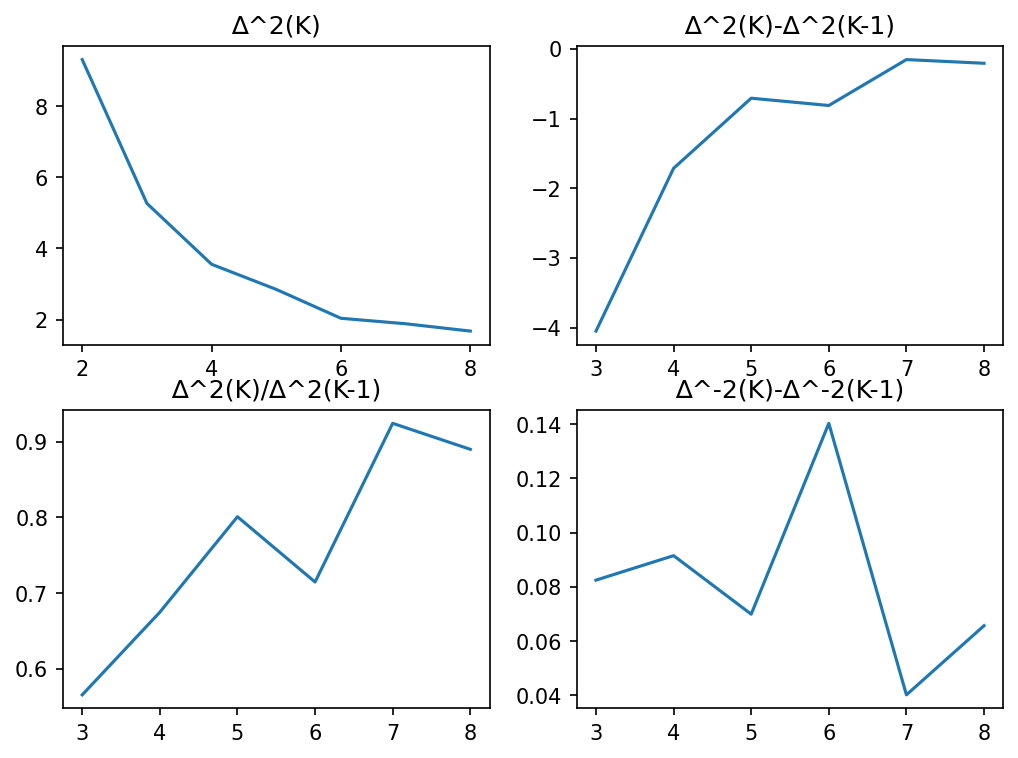

In [49]:
rate = np.array([r["loss"][-1] for r in results_kpp])
fig, axs = plt.subplots(2,2,dpi=150, figsize=(7,5))
fig.tight_layout()
axs[0][0].plot([i+2 for i in range(7)],rate)
axs[0][0].set_title('∆^2(K)')
axs[0][1].plot([i+3 for i in range(6)],rate[1:7]-rate[0:6])
axs[0][1].set_title('∆^2(K)-∆^2(K-1)')
axs[1][0].plot([i+3 for i in range(6)],rate[1:7]/rate[0:6])
axs[1][0].set_title('∆^2(K)/∆^2(K-1)')
axs[1][1].plot([i+3 for i in range(6)],1/rate[1:7]-1/rate[0:6])
axs[1][1].set_title('∆^-2(K)-∆^-2(K-1)')

In [89]:
class EMAlg(DataSection):

    def __init__(self, data: DataFrame, train: bool, n:int, k:int, d:int):
        super().__init__(data, train, n)
        self.k = k
        self.d = d
        self.m = np.zeros((k,d), np.float32)
        self.c = np.full((k,d,d), np.identity(d), np.float32)
        self.pi = np.full((k,), 1/k, np.float32)
        self.assign = np.zeros((k, self.n), np.float32)
        self.prob = np.zeros((k, self.n), np.float32)

    def step_assignment(self):
        self.prob = np.zeros((self.k, self.n), np.float32)
        for i in range(self.k):
            c = self.c[i]
            m = self.m[i]
            ic = np.linalg.inv(c)
            factor = math.sqrt((2 * math.pi) ** self.d * abs(np.linalg.det(c)))
            for j in range(self.n):
                x = self.data[j]
                upper = np.matmul(np.matmul(x - m, ic), x - m)
                self.prob[i,j] = self.pi[i] * np.exp(-upper / 2) / factor
        for j in range(self.n):
            total = sum(self.prob[:,j])
            for i in range(self.k):
                self.assign[i,j] = self.prob[i,j] / total
    
    def step_update(self):
        for i in range(self.k):
            neff = sum(self.assign[i])
            m = np.zeros((self.d,))
            for j in range(self.n):
                m += self.assign[i,j]*self.data[j]
            self.m[i] = m/neff
            c = np.zeros((self.d, self.d))
            for j in range(self.n):
                diff = self.data[j] - self.m[i]
                c += self.assign[i,j] * np.outer(diff, diff)
            self.c[i] = c/neff
            self.pi[i] = neff / self.n

    def test(self):
        sa = np.sum(self.assign * np.log(self.prob))
        sc = np.sum(self.pi)*self.n
        return sa - sc

In [140]:
def plot_em(axs: plt.Axes, model: EMAlg, s=5):
    assign = np.argmax(model.assign, 0)
    for i in range(model.k):
        data = model.data[assign==i]
        axs.scatter(data[:,0], data[:,1], s=s)
        axs.set_aspect('equal', 'box')
        axs.set_box_aspect()

def test_em(old: EMAlg, n, k):
    model = EMAlg(data, False, n, k, 2)
    model.m = old.m
    model.c = old.c
    model.pi = old.pi
    model.step_assignment()
    table = np.zeros((4,k))
    assign = np.argmax(model.assign, 0)
    tot = 0
    for i in range(4):
        for j in range(k):
            table[i,j] = np.mean(assign[model.label == i] == j)*100
            if table[i,j]>50:
                tot += np.sum(assign[model.label == i] != j)
    return {"table":table,"total":tot}

def gen_and_test_em(n):
    base = KMean(data, True, n, 4)
    random_init(base, KMean.init_kpp, 123456, 10)
    train(base, 1e-4)

    emalg = EMAlg(data, True, n, 4, 2)
    emalg.m = base.m
    emalg.step_assignment()

    prev = 1e6
    val = 0
    val_list = []
    while prev - val > 1e-4:
        emalg.step_update()
        emalg.step_assignment()
        prev = val
        val = emalg.test()
        val_list.append(val)

    fig, axs = plt.subplots(1,2, figsize=(10,5))
    
    plot_scatter(axs[0], base)
    axs[0].set_title('K-Means')
    plot_em(axs[1], emalg)
    axs[1].set_title('EM Algorithm')

    tested = test_em(emalg, 100000, 4)
    mat = np.round(tested["table"], decimals=1)
    print(mat)
    print(tested["total"])

    return {"model":emalg,"list":val_list,"mat":mat,"total":tested["total"]}



[[ 0.  96.8  0.   3.2]
 [80.1  0.1  0.  19.8]
 [ 5.4  4.6  0.1 89.9]
 [ 0.6  0.  99.3  0. ]]
8225


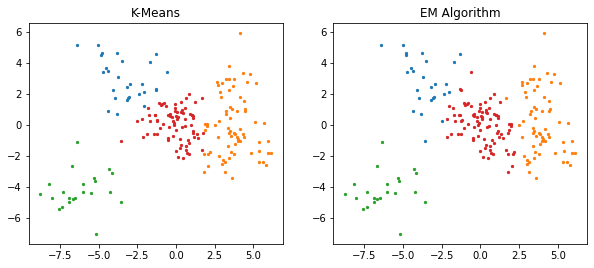

In [141]:
em200 = gen_and_test_em(200)

In [133]:
p1 = test_and_list(results_kpp[i]["m"], 100000, i+2)["total"]/n
p2 = em200["total"]/n

print(p1,p2)

0.17594 0.08225


Text(0.5, 1.0, 'EM Algorithm Loss')

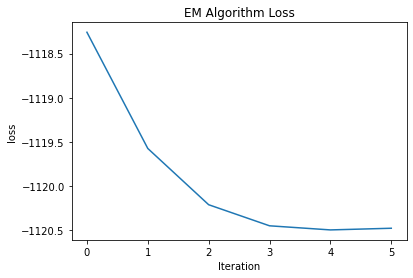

In [136]:
plt.plot(em200["list"])
plt.xlabel('Iteration')
plt.ylabel('loss')
plt.title('EM Algorithm Loss')